El objetivo es predecir el valor de venta de un inmueble basado en las caracteristicas de este. Se usara Random Forest como modelo para la prediccion. 
La data usada es proveniente de Meulborne, Australia

In [231]:

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from category_encoders.target_encoder import TargetEncoder
from skopt import BayesSearchCV
from skopt.space import Real,Categorical, Integer
import seaborn as sns
import numpy as np

In [232]:
house_data = pd.read_csv('melb_data.csv')
# print(house_data.head())
print(house_data.columns)
print(house_data.shape)

Index(['Suburb', 'Address', 'Rooms', 'Type', 'Price', 'Method', 'SellerG',
       'Date', 'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car',
       'Landsize', 'BuildingArea', 'YearBuilt', 'CouncilArea', 'Lattitude',
       'Longtitude', 'Regionname', 'Propertycount'],
      dtype='object')
(13580, 21)


In [233]:
# verificacion de data nula
pd.DataFrame(house_data.isnull().sum().sort_values(ascending=False))

,0
BuildingArea,6450
YearBuilt,5375
CouncilArea,1369
Car,62
Suburb,0
Price,0
Type,0
Rooms,0
Address,0
Distance,0


In [234]:
house_data['BuildingArea'].isnull().sum()

np.int64(6450)

In [235]:
# Se elimina los features que no son relevantes para el modelo
house_data.drop(['Address','Date','Postcode','Lattitude','Longtitude'],inplace=True,axis=1)
house_data.columns

Index(['Suburb', 'Rooms', 'Type', 'Price', 'Method', 'SellerG', 'Distance',
       'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'YearBuilt',
       'CouncilArea', 'Regionname', 'Propertycount'],
      dtype='object')

In [236]:
# Se obtiene las variables categoricas
cat_variables = [coln for coln in house_data.columns if house_data[coln].dtype == 'object']
# cat_variables.remove('SellerG')
# cat_variables.remove('Method')
cat_variables

['Suburb', 'Type', 'Method', 'SellerG', 'CouncilArea', 'Regionname']

In [237]:
# Se obtiene las variables numericas
num_variables = [coln for coln in house_data.columns if house_data[coln].dtype in ['int64', 'float64']]
num_variables.remove('Price')
# num_variables.remove('YearBuilt')
num_variables

['Rooms',
 'Distance',
 'Bedroom2',
 'Bathroom',
 'Car',
 'Landsize',
 'BuildingArea',
 'YearBuilt',
 'Propertycount']

# ANALISIS EXPLORATORIA DE LA DATA


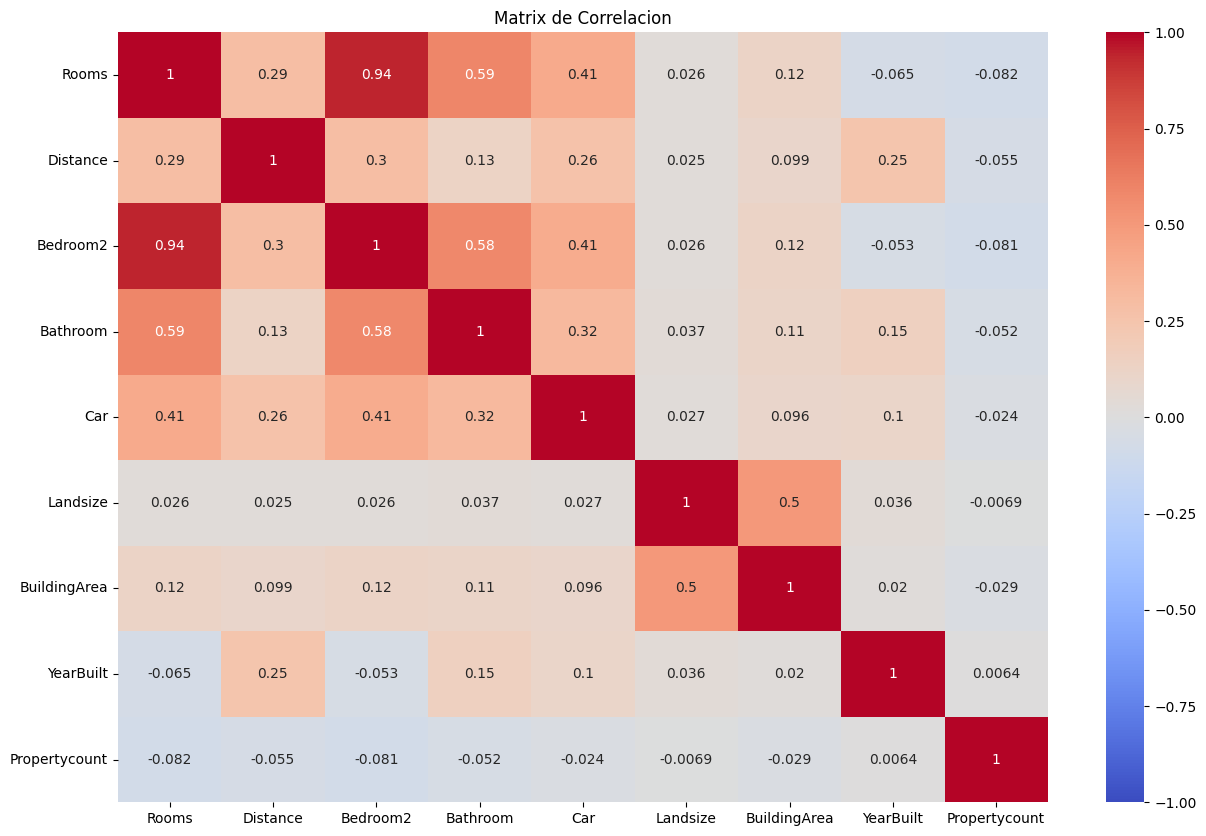

In [238]:
matrix_correlacion = house_data[num_variables].corr()
plt.figure(figsize=(15,10))
sns.heatmap(matrix_correlacion,annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1)
plt.title('Matrix de Correlacion')
plt.yticks(rotation=0)
plt.show()

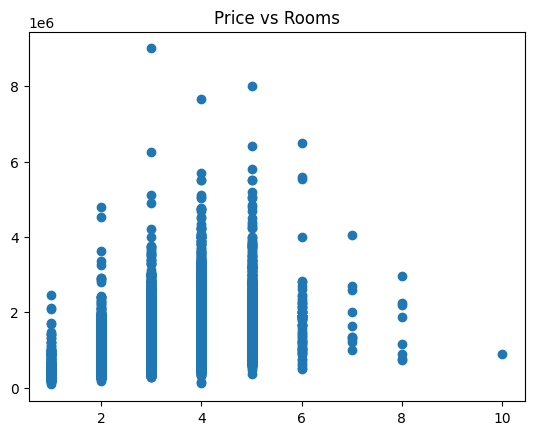

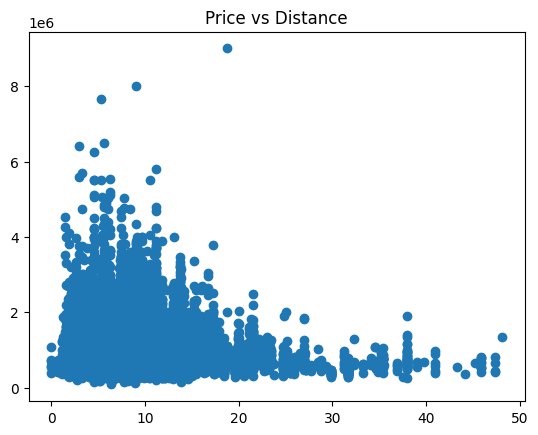

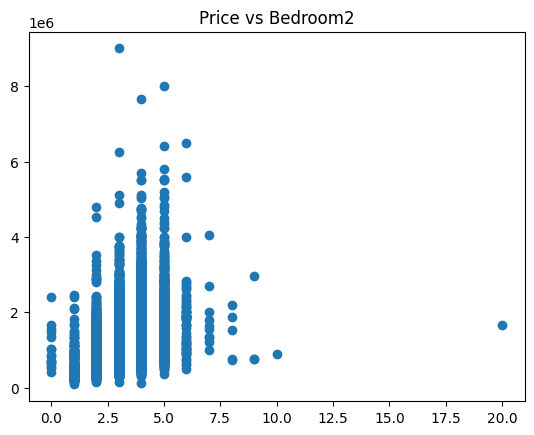

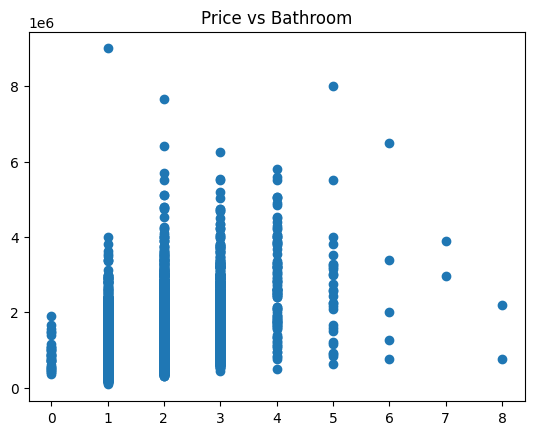

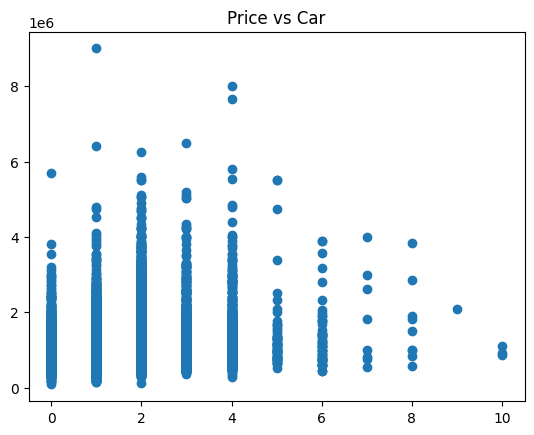

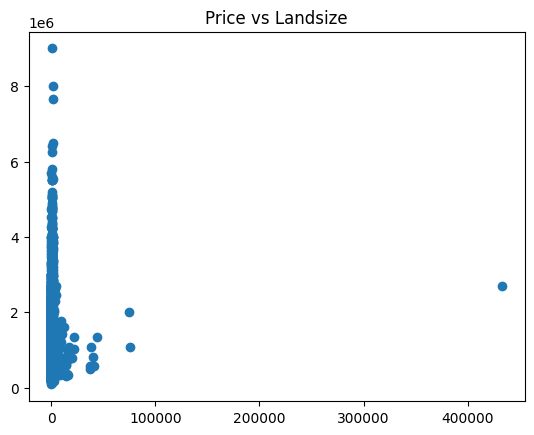

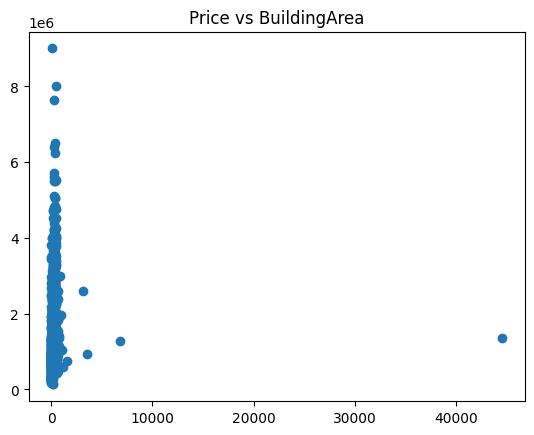

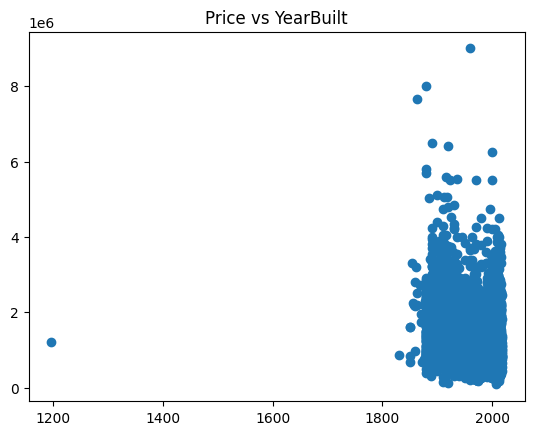

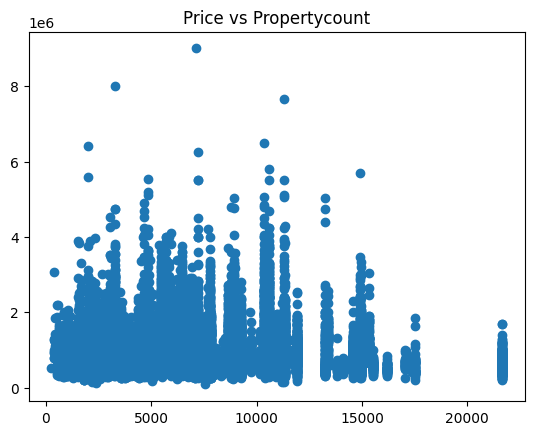

In [239]:
for col_num in num_variables:
    plt.scatter(x=house_data[col_num],y=house_data['Price'])
    plt.title(f'Price vs {col_num}')
    plt.show()

# PROCESAMIENTO DE DATA

In [240]:
# Creacion del PIPELINE con el metodo de IMPUTER para llenar los datos nulos
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

nume_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
]
   )

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder',OneHotEncoder(sparse_output=False,handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', nume_transformer, num_variables),
        ('cat', cat_transformer, cat_variables)
    ],remainder='passthrough',
    n_jobs=-1)
my_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

In [241]:

y = house_data['Price']
predictors = num_variables + cat_variables
X = house_data[predictors]

X

,Rooms,Distance,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Propertycount,Suburb,Type,Method,SellerG,CouncilArea,Regionname
0,2,2.5,2.0,1.0,1.0,202.0,NaN,NaN,4019.0,Abbotsford,h,S,Biggin,Yarra,Northern Metropolitan
1,2,2.5,2.0,1.0,0.0,156.0,79.0,1900.0,4019.0,Abbotsford,h,S,Biggin,Yarra,Northern Metropolitan
2,3,2.5,3.0,2.0,0.0,134.0,150.0,1900.0,4019.0,Abbotsford,h,SP,Biggin,Yarra,Northern Metropolitan
3,3,2.5,3.0,2.0,1.0,94.0,NaN,NaN,4019.0,Abbotsford,h,PI,Biggin,Yarra,Northern Metropolitan
4,4,2.5,3.0,1.0,2.0,120.0,142.0,2014.0,4019.0,Abbotsford,h,VB,Nelson,Yarra,Northern Metropolitan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13575,4,16.7,4.0,2.0,2.0,652.0,NaN,1981.0,7392.0,Wheelers Hill,h,S,Barry,NaN,South-Eastern Metropolitan
13576,3,6.8,3.0,2.0,2.0,333.0,133.0,1995.0,6380.0,Williamstown,h,SP,Williams,NaN,Western Metropolitan
13577,3,6.8,3.0,2.0,4.0,436.0,NaN,1997.0,6380.0,Williamstown,h,S,Raine,NaN,Western Metropolitan
13578,4,6.8,4.0,1.0,5.0,866.0,157.0,1920.0,6380.0,Williamstown,h,PI,Sweeney,NaN,Western Metropolitan


In [242]:
from sklearn import set_config
set_config(transform_output="pandas")
X_prepro = my_pipe.fit_transform(X)

In [243]:
X_train, X_test, y_train, y_test = train_test_split(X_prepro, y, test_size=0.2, random_state=2)
X_train

,num__Rooms,num__Distance,num__Bedroom2,num__Bathroom,num__Car,num__Landsize,num__BuildingArea,num__YearBuilt,num__Propertycount,cat__Suburb_Abbotsford,...,cat__CouncilArea_Yarra,cat__CouncilArea_Yarra Ranges,cat__Regionname_Eastern Metropolitan,cat__Regionname_Eastern Victoria,cat__Regionname_Northern Metropolitan,cat__Regionname_Northern Victoria,cat__Regionname_South-Eastern Metropolitan,cat__Regionname_Southern Metropolitan,cat__Regionname_Western Metropolitan,cat__Regionname_Western Victoria
6941,-0.981463,0.385485,-0.947035,-0.772376,0.406003,0.015683,-1.096146e-01,-0.161685,-0.544584,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
12969,1.111216,-0.449480,1.123604,3.564851,1.447238,-0.003863,2.730497e-01,1.736753,0.413296,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
10653,2.157555,2.873340,2.158923,6.456335,1.447238,0.085599,6.641100e-02,-0.161685,-1.121047,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
11652,0.064876,1.015969,0.088284,-0.772376,0.406003,0.041995,7.250648e-17,0.000000,-0.608534,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4871,0.064876,-0.960683,0.088284,0.673367,-0.635232,-0.111869,-1.325744e-01,-2.232709,0.059972,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2514,-0.981463,-0.739162,-0.947035,-0.772376,-0.635232,-0.139936,-2.142095e-01,1.702236,-1.024209,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
11798,-0.981463,-1.267405,-0.947035,-0.772376,-0.635232,-0.139936,7.250648e-17,0.000000,1.697549,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6637,0.064876,-0.534680,0.088284,0.673367,0.406003,-0.101845,7.250648e-17,0.000000,-0.208161,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2575,0.064876,-1.131084,0.088284,2.119109,-0.635232,-0.092824,-5.859266e-02,1.218997,-0.276451,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [244]:
#  definimos el modelo
model_rfr = RandomForestRegressor(random_state=2)

In [245]:
param_grid_rfr = {
    'max_depth': [5, 10, 15],
    'n_estimators': [100, 250, 500],
    'min_samples_split': [3, 5, 10]
}

In [246]:
model_rfr_cv = GridSearchCV(model_rfr, param_grid_rfr, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')

In [247]:
model_rfr_cv.fit(X_train, y_train)

,estimator,RandomForestR...andom_state=2)
,param_grid,"{'max_depth': [5, 10, ...], 'min_samples_split': [3, 5, ...], 'n_estimators': [100, 250, ...]}"
,scoring,'neg_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,500


In [248]:
np.sqrt(-1 * model_rfr_cv.best_score_)

np.float64(291858.0260443034)

In [249]:
model_rfr_cv.best_params_

{'max_depth': 15, 'min_samples_split': 3, 'n_estimators': 500}